<a href="https://colab.research.google.com/github/riyamendon99/CSE575-SML-Riya-Mendon/blob/main/HW5_RiyaMendon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***NAME: RIYA MENDON ASU ID: 1229584722***

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/')

In [ ]:
%pwd

'/content'

In [ ]:
%cd '/content/drive/MyDrive'

/content/drive/MyDrive


In [ ]:
import sys; sys.path.append('../..') ; sys.path.append('..') ; from my_utils import *

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
# dummy trainloader
trainloader = data.DataLoader(data.TensorDataset(torch.Tensor(1), torch.Tensor(1)), batch_size=1, shuffle=True)
device = torch.device('cpu')

import matplotlib.pyplot as plt

In this homework, we build a neural network for performing binary classification. We will base our implementation on neural ordinary differential equations (NODEs). We will again use the concentric annuli dataset.

Let's begin by importing some libaries.

Next, we set a random seed for reproducibility.

In [ ]:
import numpy as np
import random

seed = 0
np.random.seed(seed)
torch.random.manual_seed(seed)
random.seed(seed)

# Concentric annuli



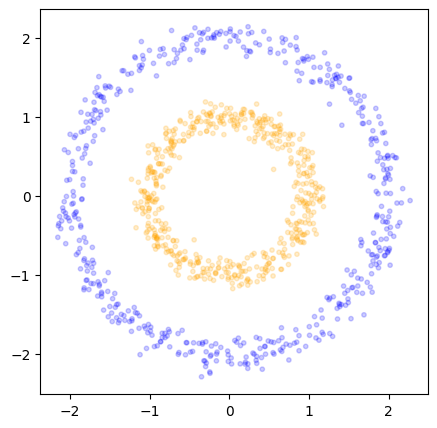

In [ ]:
Xtrain, ytrain = sample_annuli()
fig, ax = plt.subplots(1,1, figsize=(5,5))
plot_scatter(ax, Xtrain, ytrain)

First, lets see how a simple shallow neural network would perform.

In [ ]:
class Model(nn.Module):
    def __init__(self,device="cpu"):
        super(Model, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(2,50),
            nn.Tanh(),
            nn.Linear(50,50),
            nn.Tanh(),
            nn.Linear(50,1))
        #for p in self.linear_layer.parameters(): torch.nn.init.zeros_(p)

    def forward(self, x):
        y = self.net(x)
        y = torch.sigmoid(y)
        return y

In [ ]:
model = Model().to(device)

In [ ]:
optimizer = optim.AdamW(model.parameters(), lr=1e-2, weight_decay=1e-6)

In [ ]:
for itr in range(1, 501):
    optimizer.zero_grad()
#    x0, y = sample_annuli(device=device, n_samples=1024)

    yh = model(Xtrain)
    loss = nn.BCELoss()(yh.squeeze(), ytrain.float())
    print(itr,loss.item())
    #loss_traj[itr-1] = loss.item()
    loss.backward()
    optimizer.step()

1 0.693945586681366
2 0.6776142120361328
3 0.65314781665802
4 0.6346390843391418
5 0.6130549311637878
6 0.5859909057617188
7 0.5587671995162964
8 0.5281894207000732
9 0.49319690465927124
10 0.4578034281730652
11 0.4197216331958771
12 0.37944117188453674
13 0.33956608176231384
14 0.29894691705703735
15 0.2594902515411377
16 0.2226472795009613
17 0.18819482624530792
18 0.1571122407913208
19 0.13000282645225525
20 0.10624710470438004
21 0.08601048588752747
22 0.06934855878353119
23 0.055476292967796326
24 0.0441865399479866
25 0.03529287502169609
26 0.02820768766105175
27 0.022536074742674828
28 0.01809486374258995
29 0.014660939574241638
30 0.011973738670349121
31 0.009838348254561424
32 0.008139536716043949
33 0.0067976536229252815
34 0.005740583408623934
35 0.00490180728957057
36 0.004226277582347393
37 0.0036736023612320423
38 0.003216665470972657
39 0.0028375841211527586
40 0.00252340966835618
41 0.0022633117623627186
42 0.002047463320195675
43 0.0018669982673600316
44 0.001714373123

You can see that the model can easily achieve zero error.

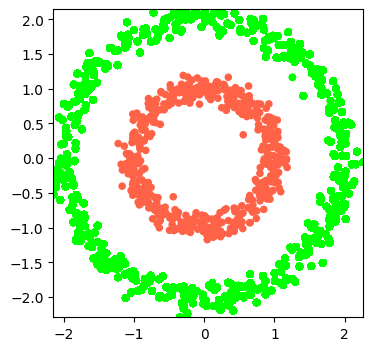

tensor(0)


In [ ]:
with torch.no_grad():
    fig = plt.figure(figsize=(4,4))
    axes = []
    axes.append(fig.add_subplot(1,1,1))#,sharex=True,sharey=True))
    xs, ys = Xtrain, ytrain#sample_gaussian(n_samples=200) ; s = torch.linspace(0, 1, 10)

    y_pred = model(xs)

    label = (y_pred[:,0] >= 0.5).long()

    colors = ['lime','tomato']
    for i in range(512):
        axes[0].scatter(xs[i,0], xs[i,1], c=colors[label[i]], edgecolor='none', s=30)
        axes[0].scatter(xs[i+512:,0], xs[i+512:,1], c=colors[label[i+512]], edgecolor='none', s=30)
    axes[0].set_xlim(xs[:,0].min(), xs[:,0].max()) ; axes[0].set_ylim(xs[:,1].min(), xs[:,1].max())
    plt.show()
    err = torch.sum(torch.abs(label) - torch.abs(ytrain))
    print(err)



# NODEs

Now, lets implement neural ODEs for the binary classification.

First, you need to install a proper API, torchdiffeq (https://github.com/rtqichen/torchdiffeq)

In [ ]:
pip install torchdiffeq

In [ ]:
from torchdiffeq import odeint

In the following (the ODEFunc class), we define the right-hand side of the neural ODEs ($f$ in the equation below).

$$ \frac{d x}{d t} = f(x;\theta) $$

In [ ]:
class ODEFunc(nn.Module):

    def __init__(self):
        super(ODEFunc, self).__init__()

        hdim = 32
        self.net = nn.Sequential(
            nn.Linear(2, hdim),
            nn.Tanh(),
            nn.Linear(hdim, hdim),
            nn.Tanh(),
            nn.Linear(hdim, 2)
        )

    def forward(self, t, y):
        return self.net(y)

The model below solves the initial value problem associated with the NODE defined above starting at $t=0$ to the terminal time $t=1$.

In [ ]:
class Model(nn.Module):
    def __init__(self,odefunc,device="cpu"):
        super(Model, self).__init__()

        self.odefunc = odefunc
        self.linear_layer = nn.Linear(2,1)
        for p in self.linear_layer.parameters(): torch.nn.init.zeros_(p)

    def forward(self, y):
        t_span = torch.linspace(0., 1., 2)
        pred_y = odeint(self.odefunc, y, t_span).to(device)
        yhat = self.linear_layer(pred_y)
        return torch.sigmoid(yhat)


In [ ]:
def dec_bound(model, x):
    P = [p for p in model.linear_layer.parameters()]
    w1, w2, b = P[0][0][0].cpu().detach(), P[0][0][1].cpu().detach(), P[1][0].cpu().detach().item()
    return (-w1*x - b + .5)/w2

1 0.6931472420692444
2 0.6930838823318481
3 0.6930156946182251
4 0.6929415464401245
5 0.6928609013557434
6 0.6927733421325684
7 0.6926784515380859
8 0.6925758123397827
9 0.6924648880958557
10 0.6923452019691467
11 0.6922160387039185
12 0.6920764446258545
13 0.6919259428977966
14 0.6917632818222046
15 0.6915879249572754
16 0.6913984417915344
17 0.6911941170692444
18 0.690973699092865
19 0.6907362937927246
20 0.6904802918434143
21 0.6902046799659729
22 0.6899080872535706
23 0.6895890831947327
24 0.6892460584640503
25 0.6888774037361145
26 0.6884815096855164
27 0.688056468963623
28 0.687600314617157
29 0.6871110796928406
30 0.6865864992141724
31 0.6860243082046509
32 0.6854220628738403
33 0.6847771406173706
34 0.684087336063385
35 0.6833497285842896
36 0.6825621724128723
37 0.6817222237586975
38 0.6808276772499084
39 0.6798765659332275
40 0.6788672208786011
41 0.6777979731559753
42 0.6766676902770996
43 0.6754754781723022
44 0.6742209196090698
45 0.672903835773468
46 0.6715248227119446
47

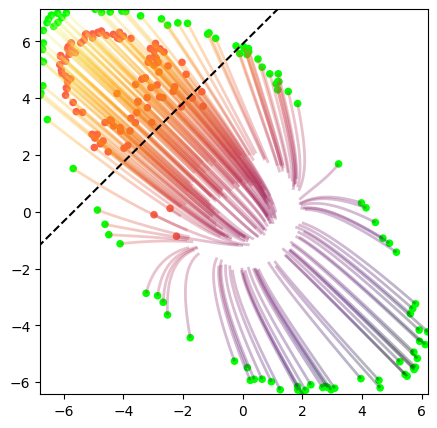

101 0.5769915580749512
102 0.5754978656768799
103 0.5740126371383667
104 0.5725376605987549
105 0.5710737705230713
106 0.569621205329895
107 0.5681794881820679
108 0.5667475461959839
109 0.5653244256973267
110 0.5639088153839111
111 0.5624998807907104
112 0.5610966682434082
113 0.5596985816955566
114 0.5583049058914185
115 0.556914746761322
116 0.5555270314216614
117 0.5541403293609619
118 0.5527534484863281
119 0.5513647198677063
120 0.5499728918075562
121 0.5485768914222717
122 0.5471758246421814
123 0.5457690358161926
124 0.5443563461303711
125 0.542937695980072
126 0.5415130853652954
127 0.5400827527046204
128 0.538646936416626
129 0.5372061133384705
130 0.5357604622840881
131 0.5343104004859924
132 0.5328564047813416
133 0.5313988327980042
134 0.5299379825592041
135 0.5284740924835205
136 0.527006983757019
137 0.5255366563796997
138 0.5240626335144043
139 0.522584080696106
140 0.5211005210876465
141 0.5196110606193542
142 0.5181151628494263
143 0.5166122317314148
144 0.51510202884

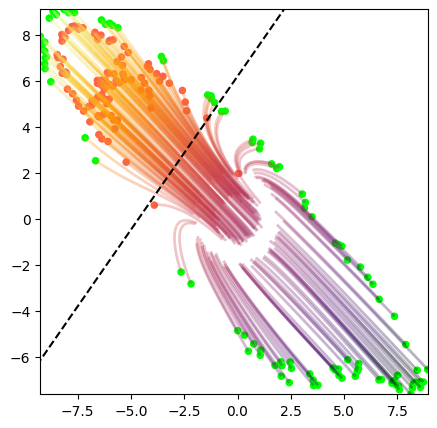

201 0.40785789489746094
202 0.4056793749332428
203 0.4035155177116394
204 0.4013667106628418
205 0.3992336392402649
206 0.39711642265319824
207 0.3950141668319702
208 0.3929254412651062
209 0.3908484876155853
210 0.38878172636032104
211 0.38672342896461487
212 0.38467225432395935
213 0.38262689113616943
214 0.3805868327617645
215 0.3785518407821655
216 0.3765209913253784
217 0.374492883682251
218 0.37246641516685486
219 0.3704410791397095
220 0.36841684579849243
221 0.3663921654224396
222 0.3643642067909241
223 0.36232990026474
224 0.3602864146232605
225 0.35822969675064087
226 0.3561534881591797
227 0.3540509045124054
228 0.3519198000431061
229 0.34976911544799805
230 0.3476095199584961
231 0.3454369306564331
232 0.3432444930076599
233 0.3410351574420929
234 0.33881324529647827
235 0.33657485246658325
236 0.3343118131160736
237 0.3320196270942688
238 0.3297002911567688
239 0.3273565173149109
240 0.32498931884765625
241 0.32259899377822876
242 0.32018303871154785
243 0.3177391886711120

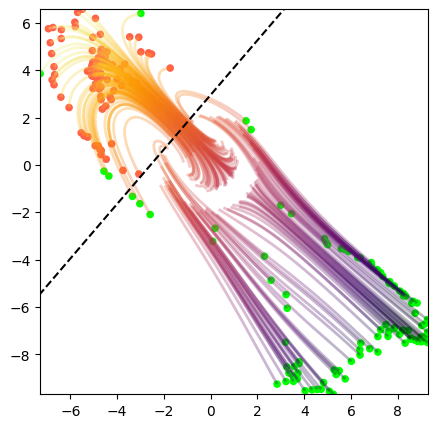

301 0.1609542816877365
302 0.15915615856647491
303 0.15738257765769958
304 0.15562793612480164
305 0.15389123558998108
306 0.15216439962387085
307 0.15044903755187988
308 0.14873500168323517
309 0.14702868461608887
310 0.14532996714115143
311 0.14365154504776
312 0.141992449760437
313 0.14034803211688995
314 0.13871881365776062
315 0.1371113657951355
316 0.13553248345851898
317 0.1340278834104538
318 0.13270016014575958
319 0.13214057683944702
320 0.12946049869060516
321 0.12915290892124176
322 0.12934115529060364
323 0.12721829116344452
324 0.1247764304280281
325 0.1248546689748764
326 0.1227244958281517
327 0.12349633127450943
328 0.12004242837429047
329 0.11968645453453064
330 0.11862596124410629
331 0.11645825207233429
332 0.1166766881942749
333 0.1148475706577301
334 0.11339469999074936
335 0.1133354976773262
336 0.11128971725702286
337 0.11095714569091797
338 0.11003125458955765
339 0.10850478708744049
340 0.10825765132904053
341 0.10692857950925827
342 0.10609458386898041
343 0.

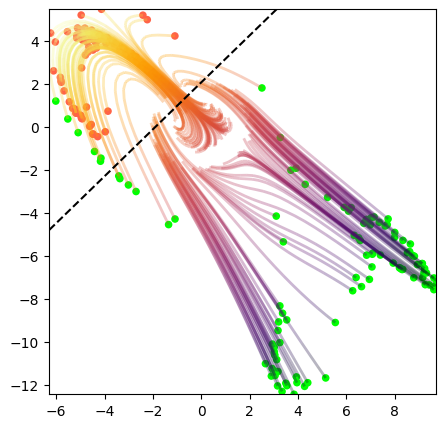

401 0.07183842360973358
402 0.07142608612775803
403 0.0710311159491539
404 0.07065421342849731
405 0.07026022672653198
406 0.06987882405519485
407 0.06951827555894852
408 0.06913851946592331
409 0.06877200305461884
410 0.06842365115880966
411 0.06805737316608429
412 0.06770674884319305
413 0.0673665851354599
414 0.06701557338237762
415 0.06668410450220108
416 0.06634511053562164
417 0.06601372361183167
418 0.06569145619869232
419 0.06536176800727844
420 0.06504777818918228
421 0.0647265613079071
422 0.06441351771354675
423 0.06410694122314453
424 0.06379660964012146
425 0.06349287927150726
426 0.06319419294595718
427 0.06289513409137726
428 0.0625995546579361
429 0.06230749934911728
430 0.06201646849513054
431 0.06172952428460121
432 0.06144370138645172
433 0.06116226315498352
434 0.06088109686970711
435 0.060603827238082886
436 0.06032719835639
437 0.06005316972732544
438 0.059781815856695175
439 0.05951128154993057
440 0.05924363434314728
441 0.058977123349905014
442 0.05871326848864

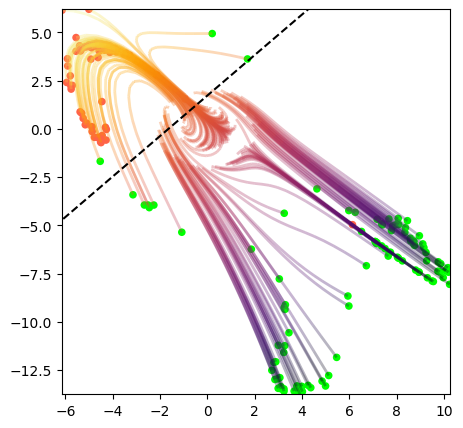

In [ ]:
from matplotlib.collections import LineCollection

ii = 0
odefunc = ODEFunc().to(device)
model = Model(odefunc).to(device)

optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-6)

for itr in range(1, 501):
    optimizer.zero_grad()
    #x0, y = sample_annuli(device=device, n_samples=1024)
    yh = model(Xtrain)
    loss = nn.BCELoss()(yh[-1], ytrain[:,None].float())
    print(itr,loss.item())
    loss.backward()
    optimizer.step()

    if itr % 100 == 0:
        with torch.no_grad():
            x0, ys = sample_annuli(n_samples=200) ; s = torch.linspace(0, 1, 20)
            xS = odeint(model.odefunc, x0, s).to(device)
            r = 1.05*torch.linspace(xS[:,:,-2].min(), xS[:,:,-2].max(), 2)
            pS = torch.cat([model.linear_layer(xS[:,i,-2:].to(device))[None,:,:] for i in range(len(x0))])

            fig, ax = plt.subplots(1, 1, figsize=(5,5), sharex=True, sharey=True)
            for i in range(len(x0)):
                x, y, p = xS[:,i,-2].numpy(), xS[:,i,-1].numpy(), model.linear_layer(xS[:,i,-2:].to(device)).view(-1).detach().cpu().numpy()
                points = np.array([x, y]).T.reshape(-1, 1, 2) ; segments = np.concatenate([points[:-1], points[1:]], axis=1)
                norm = plt.Normalize(pS.min(), pS.max())
                lc = LineCollection(segments, cmap='inferno', norm=norm, alpha=.3)
                lc.set_array(p) ; lc.set_linewidth(2) ; line = ax.add_collection(lc)
            pS_ = model.linear_layer(xS[-1,:,-2:].to(device)).view(-1).detach().cpu().numpy()

            colors = ['lime','tomato']
            for i in range(200):
                ax.scatter(xS[-1,i,-2], xS[-1,i,-1], c=colors[ys[i]], edgecolor='none', s=30)
#            ax.scatter(xS[-1,:,-2], xS[-1,:,-1], c='lime', edgecolor='none', s=30)
#            ax.scatter(xS[0,:,-2], xS[0,:,-1], c='black', alpha=.5, s=30)
            ax.plot(r, dec_bound(model, r), '--k')
            ax.set_xlim(xS[:,:,-2].min(), xS[:,:,-2].max()) ; ax.set_ylim(xS[:,:,-1].min(), xS[:,:,-1].max())
            plt.show()


In [ ]:
label = (yh[1,:,0] >= 0.5).long()

In [ ]:
print((torch.abs(label)-torch.abs(ytrain)).sum()/1024)

tensor(0.0156)


<b>[Questions]</b>

You can see that the neural ODEs fail to achieve 100% accuracy. This is somewhat odd considering that the simple shallow network could achieve 100% accuracy and NODEs are an advanced version of ResNets.

[2 pts] Can you explain why NODEs (by design) fail and are not suitable for performing this task?

***Answer: The reason behind NODEs failing to achieving 100% accuracy is because there can be 2 vectors/points whose directions/trajectories cross over. This is not possible in this case since at the point of clash, both vectors will follow the same trajectory thus preventing the NODE to accurately classify the data and are not suitable to perform this task.***

[2 pts] now implement variants of NODEs that overcome the issue of NODEs shown above. Any variant of NODE will be accepted. The resulting model should achieve 100% accuracy. Following is the one such variant. See the implementation below (Not all parts of the implementation is revealed; I removed one important block myDepthCat.)

In [ ]:
class ODEFunc(nn.Module):

    def __init__(self):
        super(ODEFunc, self).__init__()

        hdim = 32
        self.net = nn.Sequential(
            myDepthCat(1),
            nn.Linear(2+1, hdim),
            nn.Tanh(),
            myDepthCat(1),
            nn.Linear(hdim+1, hdim),
            nn.Tanh(),
            nn.Linear(hdim, 2)
        )

        #for p in self.net[-1].parameters(): torch.nn.init.zeros_(p)

    def forward(self, t, y):
        for _, module in self.net.named_modules():
            if hasattr(module, 't'):
                module.t = t
        return self.net(y)

#Concatenate depth (time) information to the input
class myDepthCat(nn.Module):
    def __init__(self, dim):
        super(myDepthCat, self).__init__()
        self.t = None
        self.dim = dim
    def forward(self, x):
        if self.t is None:
            return x
        else:
            t = torch.ones(x.size(0), self.dim).to(x.device) * self.t  #Concatenating time along the specified dimension
            return torch.cat((x, t), dim=1)

In [ ]:
class Model(nn.Module):
    def __init__(self,odefunc,device="cpu"):
        super(Model, self).__init__()

        self.odefunc = odefunc
        self.linear_layer = nn.Linear(2,1)
        for p in self.linear_layer.parameters(): torch.nn.init.zeros_(p)

    def forward(self, y):
        t_span = torch.linspace(0., 1., 2)
        pred_y = odeint(self.odefunc, y, t_span).to(device)
        yhat = self.linear_layer(pred_y)
        return yhat


1 0.6931472420692444
2 0.6930944323539734
3 0.6930364370346069
4 0.69297194480896
5 0.6929004192352295
6 0.6928216218948364
7 0.6927350163459778
8 0.6926400661468506
9 0.6925363540649414
10 0.6924233436584473
11 0.6923003196716309
12 0.6921670436859131
13 0.6920228004455566
14 0.6918668746948242
15 0.6916986107826233
16 0.691517174243927
17 0.691321849822998
18 0.69111168384552
19 0.6908857822418213
20 0.6906430721282959
21 0.6903824806213379
22 0.6901025176048279
23 0.6898015737533569
24 0.6894779801368713
25 0.6891297101974487
26 0.6887546181678772
27 0.6883504390716553
28 0.6879147887229919
29 0.6874452233314514
30 0.6869391202926636
31 0.6863941550254822
32 0.685807466506958
33 0.6851767897605896
34 0.6844993233680725
35 0.6837728023529053
36 0.6829949617385864
37 0.6821637153625488
38 0.681277334690094
39 0.6803343296051025
40 0.6793335676193237
41 0.6782742142677307
42 0.6771560907363892
43 0.6759791970252991
44 0.6747438907623291
45 0.6734510660171509
46 0.6721019744873047
47 0.

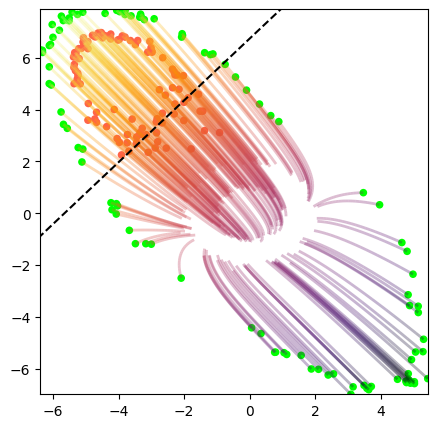

101 0.5852055549621582
102 0.5835679769515991
103 0.5819391012191772
104 0.580315351486206
105 0.5786923170089722
106 0.5770673751831055
107 0.5754403471946716
108 0.57381272315979
109 0.5721859931945801
110 0.5705614686012268
111 0.5689394474029541
112 0.5673196315765381
113 0.5657014846801758
114 0.5640843510627747
115 0.5624675750732422
116 0.5608506798744202
117 0.5592333674430847
118 0.5576148629188538
119 0.5559938549995422
120 0.5543687343597412
121 0.5527375340461731
122 0.551098108291626
123 0.5494495034217834
124 0.5477917790412903
125 0.5461260080337524
126 0.5444537997245789
127 0.5427762269973755
128 0.5410940051078796
129 0.5394079089164734
130 0.5377190709114075
131 0.5360284447669983
132 0.53433758020401
133 0.5326473712921143
134 0.5309580564498901
135 0.5292689800262451
136 0.5275784730911255
137 0.5258842706680298
138 0.5241835713386536
139 0.5224735140800476
140 0.5207514762878418
141 0.5190167427062988
142 0.5172699689865112
143 0.5155120491981506
144 0.51374369859

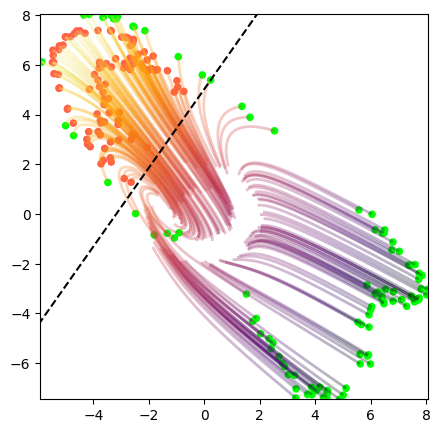

201 0.3555116653442383
202 0.35208815336227417
203 0.34867560863494873
204 0.34527531266212463
205 0.34188932180404663
206 0.33852052688598633
207 0.3351714015007019
208 0.33184391260147095
209 0.3285396993160248
210 0.3252597749233246
211 0.32200518250465393
212 0.3187769949436188
213 0.3155768811702728
214 0.3124066889286041
215 0.30926841497421265
216 0.3061639070510864
217 0.3030950427055359
218 0.3000633716583252
219 0.2970700263977051
220 0.29411599040031433
221 0.2912020683288574
222 0.28832945227622986
223 0.28549924492836
224 0.28271251916885376
225 0.279969722032547
226 0.277271032333374
227 0.2746160924434662
228 0.27200400829315186
229 0.2694335877895355
230 0.2669033110141754
231 0.26441165804862976
232 0.26195719838142395
233 0.25953835248947144
234 0.2571534514427185
235 0.25480079650878906
236 0.25247859954833984
237 0.2501850724220276
238 0.24791845679283142
239 0.245677188038826
240 0.24345962703227997
241 0.24126435816287994
242 0.23908986151218414
243 0.236934527754

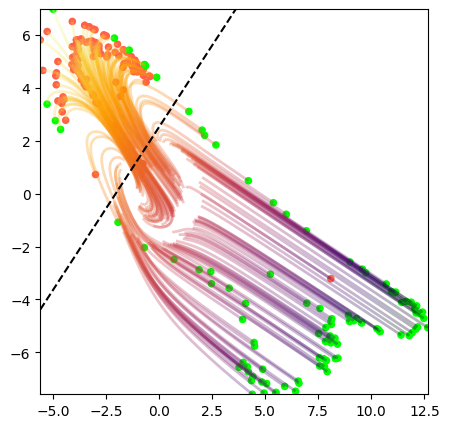

301 0.11905139684677124
302 0.11701846867799759
303 0.1150018572807312
304 0.11300265789031982
305 0.11102192848920822
306 0.10906056314706802
307 0.10711944103240967
308 0.10519911348819733
309 0.1033003181219101
310 0.10142365097999573
311 0.09956955909729004
312 0.09773853421211243
313 0.09593081474304199
314 0.09414663165807724
315 0.0923861414194107
316 0.09064935147762299
317 0.08893623948097229
318 0.08724665641784668
319 0.08558044582605362
320 0.08393749594688416
321 0.08231757581233978
322 0.08072041720151901
323 0.07914574444293976
324 0.07759332656860352
325 0.076062873005867
326 0.07455408573150635
327 0.07306670397520065
328 0.07160049676895142
329 0.07015522569417953
330 0.06873076409101486
331 0.06732682883739471
332 0.06594330072402954
333 0.0645800456404686
334 0.06323687732219696
335 0.061913684010505676
336 0.060610346496105194
337 0.05932675302028656
338 0.05806281417608261
339 0.05681842565536499
340 0.05559355765581131
341 0.05438806861639023
342 0.05320195108652

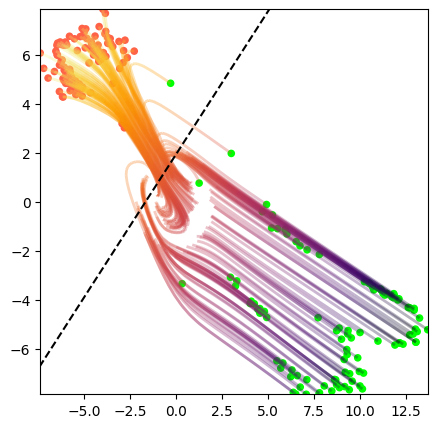

401 0.01476526353508234
402 0.014502362348139286
403 0.01424628309905529
404 0.013996852561831474
405 0.013753831386566162
406 0.013517034240067005
407 0.013286258094012737
408 0.013061314821243286
409 0.012842027470469475
410 0.012628223747015
411 0.01241972204297781
412 0.012216371484100819
413 0.012018004432320595
414 0.011824483051896095
415 0.011635650880634785
416 0.01145137008279562
417 0.01127149909734726
418 0.011095911264419556
419 0.010924482718110085
420 0.010757079347968102
421 0.010593578219413757
422 0.010433892719447613
423 0.010277890600264072
424 0.010125460103154182
425 0.009976505301892757
426 0.009830926544964314
427 0.009688631631433964
428 0.009549514390528202
429 0.009413492865860462
430 0.009280484169721603
431 0.009150389581918716
432 0.009023130871355534
433 0.008898635394871235
434 0.00877682026475668
435 0.008657610043883324
436 0.008540943264961243
437 0.008426737040281296
438 0.008314921520650387
439 0.008205440826714039
440 0.008098236285150051
441 0.007

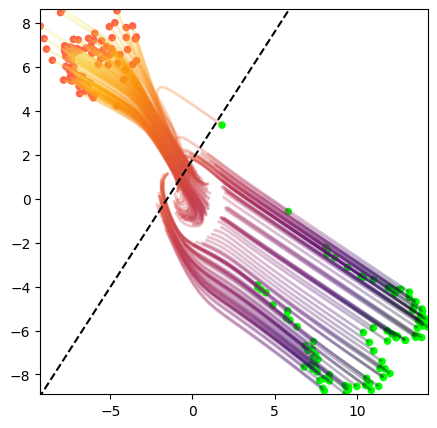

In [ ]:
from matplotlib.collections import LineCollection

ii = 0
odefunc = ODEFunc().to(device)
model = Model(odefunc).to(device)

optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-6)

for itr in range(1, 501):
    optimizer.zero_grad()
    #x0, y = sample_annuli(device=device, n_samples=1024)
    yh = model(Xtrain)
    loss = nn.BCELoss()(torch.sigmoid(yh[-1]), ytrain[:,None].float())
    print(itr,loss.item())
    loss.backward()
    optimizer.step()

    if itr % 100 == 0:
        with torch.no_grad():
            x0, ys = sample_annuli(n_samples=200) ; s = torch.linspace(0, 1, 20)
            xS = odeint(model.odefunc, x0, s).to(device)
            r = 1.05*torch.linspace(xS[:,:,-2].min(), xS[:,:,-2].max(), 2)
            pS = torch.cat([model.linear_layer(xS[:,i,-2:].to(device))[None,:,:] for i in range(len(x0))])

            fig, ax = plt.subplots(1, 1, figsize=(5,5), sharex=True, sharey=True)
            for i in range(len(x0)):
                x, y, p = xS[:,i,-2].numpy(), xS[:,i,-1].numpy(), model.linear_layer(xS[:,i,-2:].to(device)).view(-1).detach().cpu().numpy()
                points = np.array([x, y]).T.reshape(-1, 1, 2) ; segments = np.concatenate([points[:-1], points[1:]], axis=1)
                norm = plt.Normalize(pS.min(), pS.max())
                lc = LineCollection(segments, cmap='inferno', norm=norm, alpha=.3)
                lc.set_array(p) ; lc.set_linewidth(2) ; line = ax.add_collection(lc)
            pS_ = model.linear_layer(xS[-1,:,-2:].to(device)).view(-1).detach().cpu().numpy()
            colors = ['lime','tomato']
            for i in range(200):
                ax.scatter(xS[-1,i,-2], xS[-1,i,-1], c=colors[ys[i]], edgecolor='none', s=30)

            ax.plot(r, dec_bound(model, r), '--k')
            ax.set_xlim(xS[:,:,-2].min(), xS[:,:,-2].max()) ; ax.set_ylim(xS[:,:,-1].min(), xS[:,:,-1].max())
            plt.show()


In [ ]:
label = (yh[1,:,0] >= 0.5).long()
print((torch.abs(label)-torch.abs(ytrain)).sum()/1024)

tensor(0.)


In [ ]:
accuracy = (label==ytrain).sum()/1024
print("Model Accuracy is: ", accuracy.item())

Model Accuracy is:  1.0
